In [3]:
import pickle
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

with open('data/20x20.pkl', 'rb') as f:
    data = pickle.load(f)
    
conditional_freq = data[0]
action_freq = data[1]

In [4]:
import random

random.seed(1)

def match(proposedList, comparisonList):
    intersect = set(proposedList).intersection(set(comparisonList))
    return len(list(intersect))/len(proposedList) # Percentage match

    
def score_proposal(proposal, conditional_freq, action_freq, ingredient_list, action_list):
    '''
    We expect proposal to be a list where the first element is an action, and the rest are ingredients
    '''
    action = proposal[0]
    isolated_ingredients = isolate_ingredients(proposal, ingredient_list)
    isolated_actions = isolate_actions(proposal, action_list)[1:]
    
    ingredient_score = 0
    for item in conditional_freq[action].items():
        ingredient_score += match(isolated_ingredients, item[0])
    ingredient_score /= sum(list(conditional_freq[action].values()))
    
    action_score = 0
    if len(isolated_actions) == 0:
        action_score = 1
    else:
        for item in action_freq[action].items():
            action_score += match(isolated_actions, item[0])
        action_score /= sum(list(action_freq[action].values()))
        
    return ingredient_score * action_score


def isolate_ingredients(proposal, ingredient_list):
    result = []
    for elem in proposal:
        if type(elem) == list:
            result.extend(isolate_ingredients(elem, ingredient_list))
        elif elem in ingredient_list:
            result.append(elem)
        else:
            pass
            # print(elem)
            
    return result

def isolate_actions(proposal, action_list):
    result = []
    for elem in proposal:
        if type(elem) == list:
            result.extend(isolate_actions(elem, action_list))
        elif elem in action_list:
            result.append(elem)
        else:
            pass
            # print(elem)
            
    return result

In [5]:
class Hypergraph:
    def __init__(self, ingredients, actions):
        '''
            self.hyperedges is a list of pairs whose first elemnent is the set containing the
            source vertices, and the second element is the set contianing the destination 
            vertices
        '''
        self.ingredients = ingredients
        self.actions = actions
        
        self.vertices = deepcopy(ingredients)
        self.available_vertices = deepcopy(ingredients)
        
        self.transitions = {}
        self.num_hyperedges = 0
        
        self.tagged_proposals= []
        self.step_number = 0
        
    def propose_new_hyperedge(self):
        proposed_action = random.choice(list(action_freq.keys()))
        
        # Now, we pick a double or triple of available vertices
        if len(self.available_vertices) >= 3 and random.uniform(0, 1) < 0.3:
            k = 3
        else:
            k = 2
           
        vertices = random.sample(self.available_vertices, k=k)
        action = random.choice(self.actions)
        proposal = [action] + vertices
        
        return proposal
            
    def generate_over_samples(self):
        # First, we produce a distribution of scores given the current state of the hypergraph
        SAMPLES = 100
        data = []
        
        for i in range(100):
            proposal = self.propose_new_hyperedge()
            data.append(score_proposal(proposal, conditional_freq, action_freq, self.ingredients, self.actions))
        
        mean = np.mean(data)
        std = np.std(data)
        
        # We assume normal distribution since iid
        while True:
            proposal = self.propose_new_hyperedge()
            distn = scipy.stats.norm(mean, std)
            score = score_proposal(proposal, conditional_freq, action_freq, self.ingredients, self.actions)
            prob = distn.cdf(score)
            
            # Accept hyperedge
            if random.uniform(0, 1) <= prob:
                for item in proposal[1:]:
                    # print(item, proposal, self.available_vertices)
                    self.available_vertices.remove(item)
                
                self.available_vertices.append(proposal)
                self.num_hyperedges += 1
                
                self.tagged_proposals.append((proposal, self.step_number))
                self.step_number += 1
                break
        
            
    def complete(self):
        while len(self.available_vertices) != 1:
            self.generate_over_samples()
        
        return 

In [6]:
action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

h = Hypergraph(deepcopy(ingredient_list), deepcopy(action_list))
h.complete()

In [7]:
h.available_vertices[0]

['Combine',
 ['Cook', 'salt', ['Combine', 'water', 'flour', 'butter']],
 ['Mix', 'sugars', 'leavening agent']]

## Generate full transition matrix

We now traverse through all possible states to determine that 'real' transition probabilities based on the
normalized score values on all possible outgoing edges

In [28]:
import itertools

# We're going to ditch the hypergraph class since it turns out we didn't need it as much as I thought

initial_ingredient_list = ['butter', 'cream', 'water']
initial_action_list = ['Mix', 'Combine', 'Pour']

vertices = deepcopy(initial_ingredient_list)
transitions = dict()

def stringify(L):
    output = "("
    for i in range(len(L)):
        if type(L[i]) == str:
            output += L[i]
        else:
            output += stringify(L[i])
        
        if i != len(L)-1:
            output += ', '
            
    output += ")"
    return output

def process_state(vertices, initial_ingredient_list, initial_action_list, transitions):
    proposals = []
    scores = []
    
    # k = 3
    for combination in itertools.combinations(vertices, 3):
        for action in initial_action_list:
            proposal = [action] + list(combination)
            score = score_proposal(proposal, conditional_freq, action_freq, initial_ingredient_list,\
                                   initial_action_list)
            
            proposals.append(proposal)
            scores.append(score)
           
    # k = 2
    for combination in itertools.combinations(vertices, 2):
        for action in initial_action_list:
            proposal = [action] + list(combination)
            score = score_proposal(proposal, conditional_freq, action_freq,\
                                   initial_ingredient_list, initial_action_list)
            
            proposals.append(proposal)
            scores.append(score)

    string_ver = stringify(vertices)
    if len(proposals) == 0:
        transitions[string_ver] = [(string_ver, 1)]
        return
    
    if string_ver not in transitions:
        transitions[string_ver] = []
    
    score_sum = sum(scores)
        
    # Go through each transition
    for i, proposal in enumerate(proposals):
        vertex_copy = deepcopy(vertices)
        vertex_copy = [i for i in vertex_copy if i not in proposal]
        vertex_copy.append(proposal)
        
        transitions[string_ver].append((stringify(vertex_copy), scores[i]/score_sum))
        
    for i, proposal in enumerate(proposals):
        vertex_copy = deepcopy(vertices)
        vertex_copy = [i for i in vertex_copy if i not in proposal]
        vertex_copy.append(proposal)
        
        process_state(deepcopy(vertex_copy), initial_ingredient_list, initial_action_list, transitions)
        
        
        
process_state(deepcopy(initial_ingredient_list), initial_ingredient_list, initial_action_list, transitions)

print(transitions['(butter, cream, water)'])

[('((Mix, butter, cream, water))', 0.07861366378483191), ('((Combine, butter, cream, water))', 0.10089469528385069), ('((Pour, butter, cream, water))', 0.07049164093131743), ('(water, (Mix, butter, cream))', 0.08018593706052855), ('(water, (Combine, butter, cream))', 0.11290596853192814), ('(water, (Pour, butter, cream))', 0.07517272646191271), ('(cream, (Mix, butter, water))', 0.08678948481845444), ('(cream, (Combine, butter, water))', 0.10449807725827391), ('(cream, (Pour, butter, water))', 0.07517272646191271), ('(butter, (Mix, cream, water))', 0.06886556947551276), ('(butter, (Combine, cream, water))', 0.08528004006134998), ('(butter, (Pour, cream, water))', 0.06112946987012682)]


In [10]:
states = list(transitions.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([])
    for j in range(len(state_enumeration)):
        matrix[i].append(0.0)
    
# Fill in the transition probabilities
for key in transitions:
    for pair in transitions[key]:
        source_idx = state_enumeration[key]
        # print(pair)
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
print(matrix[8])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1247580125839722, 0.5803835000647566, 0.29485848735127124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


## Analysis of transition matrix

Eigenvectors, Eigenvalues, etc.

In [35]:
x_0 = np.array([1] + [0]*(len(matrix)-1))
x = 5*x_0
x_new = x_0
P = np.array(matrix)
while np.linalg.norm(x_new-x) > 0.0001:
    x = x_new
    x_new = np.matmul(x, P)
    
print(x_new)
np.nonzero(x_new)

[0.         0.07861366 0.1008947  0.07049164 0.         0.05317695
 0.00627421 0.02073477 0.         0.01408592 0.06552876 0.03329128
 0.         0.00636731 0.00340594 0.06539947 0.         0.05755623
 0.00679091 0.02244234 0.         0.01303697 0.06064896 0.03081214
 0.         0.00636731 0.00340594 0.06539947 0.         0.04566962
 0.00538844 0.01780751 0.         0.01063937 0.04949513 0.02514554
 0.         0.00517782 0.00276967 0.05318198]
0.9999999999999997


## Getting some model output statistics

We now have to test how "good" our model is by cross-referencing some common statistics between our training 
dataset and our generated dataset to see how similar they are.

In [12]:
import json

# First, we get the average length of a recipe in the dataset
with open('./data/recipes_with_nutritional_info.json') as f:
    dataset = json.load(f)

In [13]:
# Average number of hyperedges
dataset_hyperedge_list = []
for entry in random.sample(dataset, k=100):
    dataset_hyperedge_list.append(len(entry['instructions']))
dataset_mean = np.mean(dataset_hyperedge_list)

In [14]:
# Average number of hyperedges
NUM_SAMPLES = 100

generated_hyperedge_list = []

for i in range(NUM_SAMPLES):
    action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
    ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

    h = Hypergraph(deepcopy(ingredient_list), deepcopy(action_list))
    h.complete()
    
    generated_hyperedge_list.append(h.num_hyperedges)
    
generated_mean = np.mean(generated_hyperedge_list)

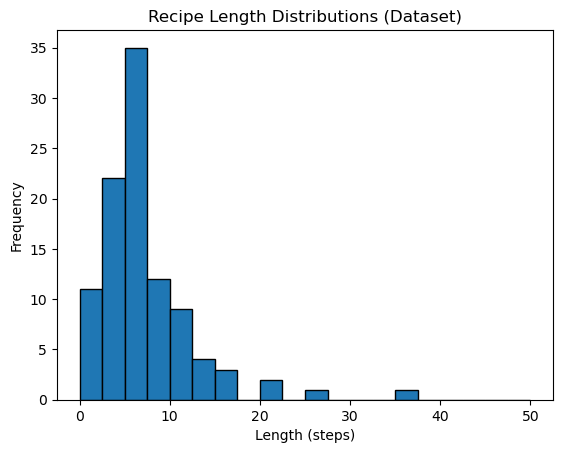

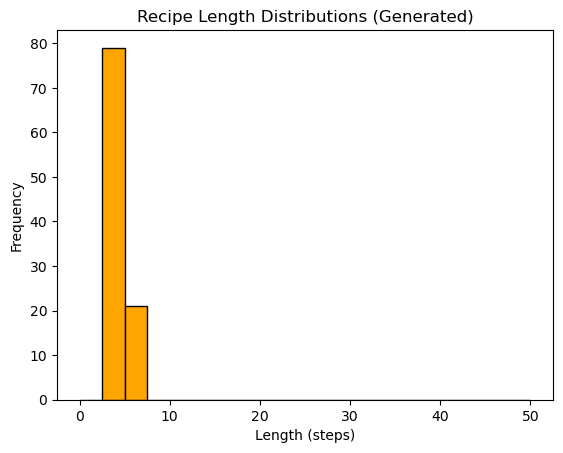

In [15]:
plt.title('Recipe Length Distributions (Dataset)')
plt.ylabel('Frequency')
plt.xlabel('Length (steps)')

plt.hist(dataset_hyperedge_list, label="Dataset", edgecolor='black', range=[0, 50], bins=20)
plt.show()

plt.title('Recipe Length Distributions (Generated)')
plt.ylabel('Frequency')
plt.xlabel('Length (steps)')

plt.hist(generated_hyperedge_list, label="Generated", color='orange', edgecolor='black', range=[0, 50], bins=20)
plt.show()

In [16]:
action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

# Time of use of ingredients
datasetUseTimes = {ingredient: [] for ingredient in ingredient_list}
for entry in dataset:
    instructions = [item['text'] for item in entry['instructions']]
    for i in range(len(instructions)):
        tokenized = instructions[i].split(' ')
        for token in tokenized:
            if token in ingredient_list:
                datasetUseTimes[token].append((i+1)/len(instructions))

In [17]:
# Average number of hyperedges
NUM_SAMPLES = 100
action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

generatedUseTimes = {ingredient: [] for ingredient in ingredient_list}

for i in range(NUM_SAMPLES):
    h = Hypergraph(deepcopy(ingredient_list), deepcopy(action_list))
    h.complete()
    
    for item in h.tagged_proposals:
        proposal = item[0]
        step = item[1]
        
        for elem in proposal:
            if elem in ingredient_list:
                generatedUseTimes[elem].append((step+1)/h.step_number)

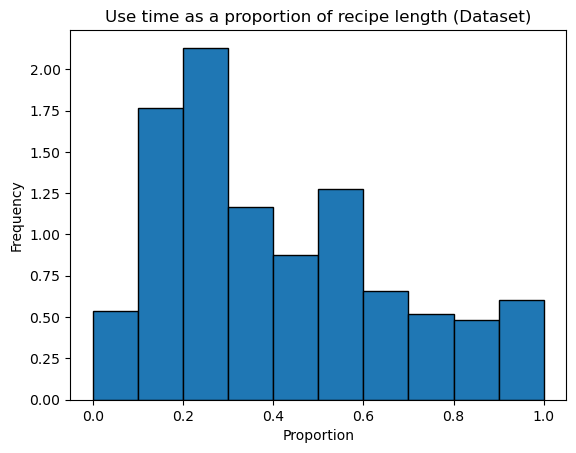

(array([0. , 0. , 4. , 1.4, 0.3, 2.2, 0.7, 0.7, 0.1, 0.6]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

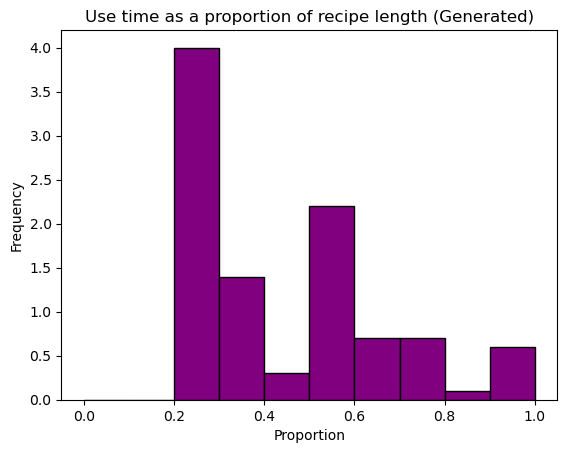

In [18]:
plt.title('Use time as a proportion of recipe length (Dataset)')
plt.ylabel('Frequency')
plt.xlabel('Proportion')
plt.hist(datasetUseTimes['butter'], density=True, range=[0, 1], edgecolor='black')
plt.show()

plt.title('Use time as a proportion of recipe length (Generated)')
plt.ylabel('Frequency')
plt.xlabel('Proportion')
plt.hist(generatedUseTimes['butter'], density=1, range=[0, 1], color='purple', edgecolor='black')

(array([ 5448.,  6080.,  1631.,  3425.,  6280., 10542., 15239.,  7547.,
         9341.,  8641.,  5834.,  2657.,  7443.,  2811.,  2224.,   467.,
          335.,  1663.,  1433.,   959.]),
 array([0.        , 0.00041935, 0.00083869, 0.00125804, 0.00167739,
        0.00209674, 0.00251608, 0.00293543, 0.00335478, 0.00377413,
        0.00419347, 0.00461282, 0.00503217, 0.00545152, 0.00587086,
        0.00629021, 0.00670956, 0.00712891, 0.00754825, 0.0079676 ,
        0.00838695]),
 <BarContainer object of 20 artists>)

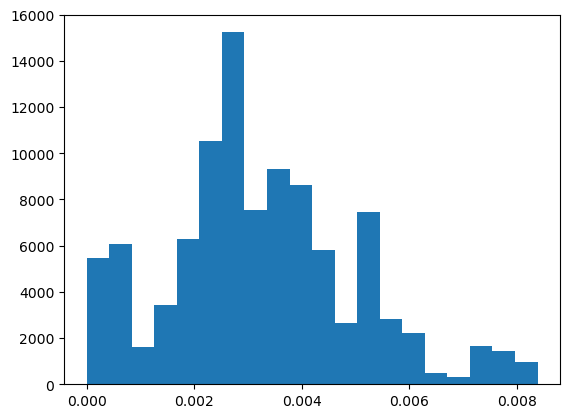

In [22]:
# Score frequency distributions
action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

vertices = deepcopy(ingredient_list)
score_dist = []

SAMPLE_SIZE = 100000

for i in range(SAMPLE_SIZE):
    if random.uniform(0, 1) < 0.5:
        k = 3
    else:
        k = 2
        
    sample = random.sample(vertices, k=k)
    action = random.choice(action_list)
    proposal = [action] + sample
    
    score = score_proposal(proposal, conditional_freq, action_freq, ingredient_list, action_list)
    score_dist.append(score)
    

plt.hist(score_dist, bins=20)

(array([ 5448.,  6080.,  1631.,  3425.,  6280., 10542., 15239.,  7547.,
         9341.,  8641.,  5834.,  2657.,  7443.,  2811.,  2224.,   467.,
          335.,  1663.,  1433.,   959.]),
 array([0.        , 0.00041935, 0.00083869, 0.00125804, 0.00167739,
        0.00209674, 0.00251608, 0.00293543, 0.00335478, 0.00377413,
        0.00419347, 0.00461282, 0.00503217, 0.00545152, 0.00587086,
        0.00629021, 0.00670956, 0.00712891, 0.00754825, 0.0079676 ,
        0.00838695]),
 <BarContainer object of 20 artists>)

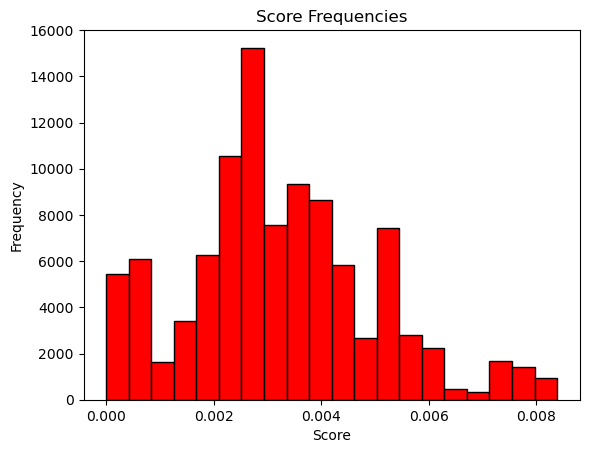

In [23]:
plt.title('Score Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.hist(score_dist, bins=20, edgecolor='black', color='red')

## Sensitivity Analysis
We substitute an ingredient and action with something similar, and see how much it changes the distribution of outcomes.

In [60]:
ingredients_1 = ['milk', 'butter', 'flour']
actions_1 = ['Stir', 'Bake', 'Combine']

ingredients_2 = ['cream', 'butter', 'flour']
actions_2 = ['Stir', 'Bake', 'Combine']

ingredients_3 = ['milk', 'butter', 'flour']
actions_3 = ['Mix', 'Bake', 'Combine']

ingredients_4 = ['onion', 'oil', 'milk']
actions_4 = ['Stir', 'Bake', 'Combine']

transitions1 = {}
transitions2 = {}
transitions3 = {}
transitions4 = {}

process_state(deepcopy(ingredients_1), ingredients_1, actions_1, transitions1)
process_state(deepcopy(ingredients_2), ingredients_2, actions_2, transitions2)
process_state(deepcopy(ingredients_3), ingredients_3, actions_3, transitions3)
process_state(deepcopy(ingredients_4), ingredients_4, actions_4, transitions4)

[0.         0.06347963 0.08337062 0.10314975 0.         0.04664296
 0.04079694 0.00777954 0.         0.00413988 0.11734374 0.0035723
 0.         0.02122865 0.06522184 0.06827414 0.         0.01973356
 0.01726025 0.00329134 0.         0.00143155 0.04057681 0.00123528
 0.         0.00780824 0.02398964 0.02511233 0.         0.0269094
 0.0235367  0.0044882  0.         0.00270834 0.07676693 0.00233702
 0.         0.01342041 0.0412322  0.04316181]


(array([ 1,  2,  3,  5,  6,  7,  9, 10, 11, 13, 14, 15, 17, 18, 19, 21, 22,
        23, 25, 26, 27, 29, 30, 31, 33, 34, 35, 37, 38, 39]),)

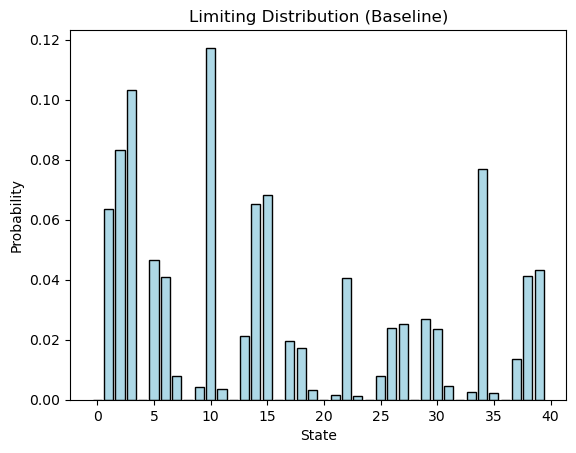

In [80]:
states = list(transitions1.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([])
    for j in range(len(state_enumeration)):
        matrix[i].append(0.0)
    
# Fill in the transition probabilities
for key in transitions1:
    for pair in transitions1[key]:
        source_idx = state_enumeration[key]
        # print(pair)
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
x_0 = np.array([1] + [0]*(len(matrix)-1))
x = 5*x_0
x_new = x_0
P = np.array(matrix)
while np.linalg.norm(x_new-x) > 0.0001:
    x = x_new
    x_new = np.matmul(x, P)
    
print(x_new)

plt.title('Limiting Distribution (Baseline)')
plt.xlabel('State')
plt.ylabel('Probability')
plt.bar(range(0, 40), x_new, color='lightblue', edgecolor='black')

baseline = x_new
np.nonzero(x_new)

[0.         0.06158732 0.08232592 0.10608676 0.         0.04469216
 0.03978685 0.00790197 0.         0.00401404 0.11580306 0.00367179
 0.         0.02111486 0.06602761 0.07198767 0.         0.01939471
 0.01726599 0.00342916 0.         0.00148266 0.0427741  0.00135625
 0.         0.00876042 0.02739443 0.02986723 0.         0.02529745
 0.02252086 0.00447281 0.         0.00253138 0.07302896 0.00231554
 0.         0.01235444 0.03863317 0.04212045]
0.03860603886840981


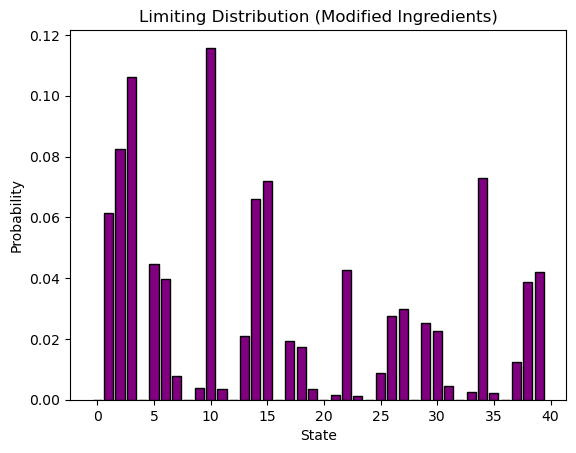

In [82]:
states = list(transitions2.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([])
    for j in range(len(state_enumeration)):
        matrix[i].append(0.0)
    
# Fill in the transition probabilities
for key in transitions2:
    for pair in transitions2[key]:
        source_idx = state_enumeration[key]
        # print(pair)
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
x_0 = np.array([1] + [0]*(len(matrix)-1))
x = 5*x_0
x_new = x_0
P = np.array(matrix)
while np.linalg.norm(x_new-x) > 0.0001:
    x = x_new
    x_new = np.matmul(x, P)
    
print(x_new)
plt.title('Limiting Distribution (Modified Ingredients)')
plt.xlabel('State')
plt.ylabel('Probability')
plt.bar(range(0, 40), x_new, color='purple', edgecolor='black')

np.nonzero(x_new)

integrated = sum(abs(baseline - x_new))
print(integrated)

[0.         0.07570409 0.07790655 0.09638936 0.         0.05257685
 0.05482511 0.00615417 0.         0.0027204  0.11076732 0.0033721
 0.         0.01442382 0.0635921  0.06656813 0.         0.02115161
 0.02205608 0.00247582 0.         0.0009407  0.03830272 0.00116605
 0.         0.00530531 0.0233902  0.02448483 0.         0.03142524
 0.03276903 0.00367836 0.         0.0017797  0.0724646  0.00220604
 0.         0.00911851 0.0402019  0.0420833 ]
0.10429717577003042


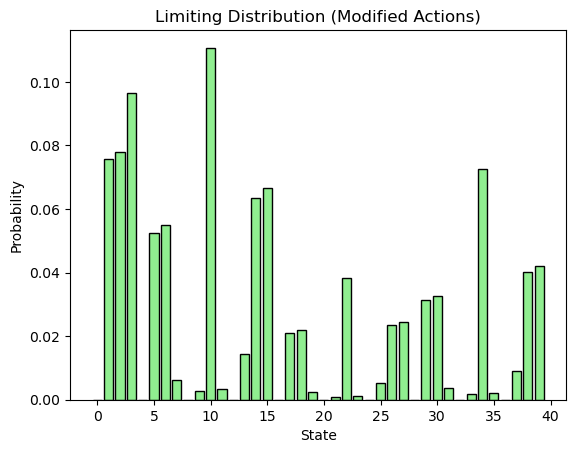

In [85]:
states = list(transitions3.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([])
    for j in range(len(state_enumeration)):
        matrix[i].append(0.0)
    
# Fill in the transition probabilities
for key in transitions3:
    for pair in transitions3[key]:
        source_idx = state_enumeration[key]
        # print(pair)
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
x_0 = np.array([1] + [0]*(len(matrix)-1))
x = 5*x_0
x_new = x_0
P = np.array(matrix)
while np.linalg.norm(x_new-x) > 0.0001:
    x = x_new
    x_new = np.matmul(x, P)
    
print(x_new)
plt.title('Limiting Distribution (Modified Actions)')
plt.xlabel('State')
plt.ylabel('Probability')
plt.bar(range(0, 40), x_new, color='lightgreen', edgecolor='black')
np.nonzero(x_new)

integrated = sum(abs(x_new - baseline))
print(integrated)

[0.         0.0724242  0.07374073 0.10383506 0.         0.02834218
 0.01921852 0.00417088 0.         0.00208662 0.04585209 0.00158865
 0.         0.01211736 0.02886183 0.03438496 0.         0.0311764
 0.02114037 0.00458797 0.         0.00257349 0.05655091 0.00195934
 0.         0.01292519 0.03078596 0.03667729 0.         0.05951857
 0.04035888 0.00875885 0.         0.00466011 0.102403   0.00354799
 0.         0.02504255 0.05964779 0.07106225]
0.41601358898122276


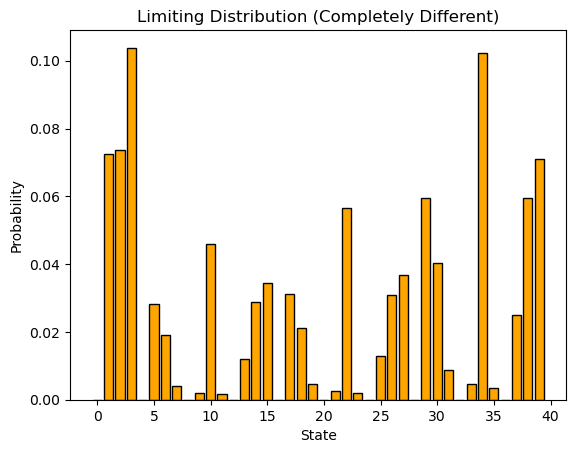

In [87]:
states = list(transitions4.keys())

# Get state -> index mapping for convenience
state_enumeration = dict()
for i in range(len(states)):
    state_enumeration[states[i]] = i

matrix = []

# Construct matrix with 0s
for i in range(len(state_enumeration)):
    matrix.append([])
    for j in range(len(state_enumeration)):
        matrix[i].append(0.0)
    
# Fill in the transition probabilities
for key in transitions4:
    for pair in transitions4[key]:
        source_idx = state_enumeration[key]
        # print(pair)
        dest_idx = state_enumeration[pair[0]]
        
        matrix[source_idx][dest_idx] = pair[1]
        
x_0 = np.array([1] + [0]*(len(matrix)-1))
x = 5*x_0
x_new = x_0
P = np.array(matrix)
while np.linalg.norm(x_new-x) > 0.0001:
    x = x_new
    x_new = np.matmul(x, P)
    
print(x_new)
plt.title('Limiting Distribution (Completely Different)')
plt.xlabel('State')
plt.ylabel('Probability')
plt.bar(range(0, 40), x_new, color='orange', edgecolor='black')
np.nonzero(x_new)

integrated = sum(abs(x_new - baseline))
print(integrated)

## Data Visualization

['Bake', 'salt', ['Pour', 'sugars', ['Stir', 'water', 'butter', 'flour'], 'leavening agent']]


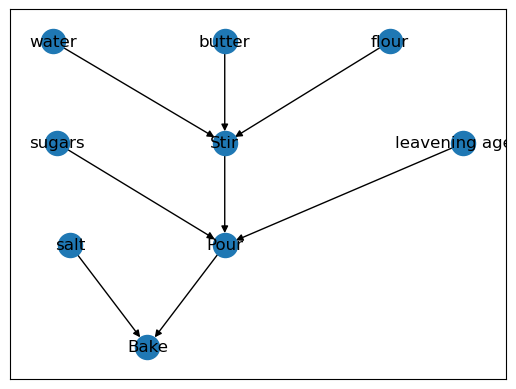

In [153]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.drawing.nx_agraph import to_agraph

action_list = ['Stir', 'Mix', 'Bake', 'Combine', 'Pour', 'Cook', 'Heat']
ingredient_list = ['water', 'flour', 'sugars', 'salt', 'leavening agent', 'butter']

h = Hypergraph(ingredient_list, action_list)
h.complete()

tree = h.available_vertices[0]
G = nx.DiGraph()

print(tree)
colors = ['red', 'blue', 'purple', 'orange', 'yellow', 'green']
idx = 0

def process_graph(tree, G, idx):
    G.add_node(tree[0])
    
    for elem in tree[1:]:
        if type(elem) == list:
            node = process_graph(elem, G, idx+1)
            G.add_edge(node, tree[0], color=colors[idx])
        else:
            G.add_node(elem)
            G.add_edge(elem, tree[0], color=colors[idx])
            
    return tree[0]


# tree = ['Bake', 'salt', 'sugars', 'butter', ['Combine', 'flour', 'water', 'leavening agent']]
process_graph(tree, G, 0)

layout = graphviz_layout(G, prog="dot")
nx.draw_networkx(G, layout)

In [154]:
pretty = to_agraph(G)
pretty.layout('dot')
pretty.draw('images/graph.png')